In [382]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [383]:
raw_data = pd.read_csv('C:/Users/adity/Downloads/seouryeok,-seoul, south korea-air-quality.csv')
data = raw_data.copy()
data

,date,pm25,pm10,o3,no2,so2,co
0,2020/4/2,95,38,24,29,4,5
1,2020/4/3,81,52,30,34,4,6
2,2020/4/4,93,54,28,18,3,4
3,2020/4/5,80,41,32,16,4,4
4,2020/4/6,70,50,26,35,4,5
...,...,...,...,...,...,...,...
2194,2014/3/21,,,17,42,6,6
2195,2014/3/22,,,11,58,10,8
2196,2014/3/23,,,23,69,14,8
2197,2014/3/24,,,19,70,12,8


In [384]:
import datetime
Date = []
for i in data.date:
    temp = i.split('/')
    Date.append(datetime.datetime(int(temp[0]),int(temp[1]),int(temp[2])))
data['Date'] = Date
data.drop(columns=['date'],inplace = True)
data.set_index('Date', inplace=True)
data = data.sort_index()
data = data.replace(" ", np.nan)
data.drop(data.tail(1).index,inplace=True)
data.drop(datetime.datetime(2020, 2, 29),inplace=True)
print(data.shape)
data.head()

(2197, 6)


,pm25,pm10,o3,no2,so2,co
Date,,,,,,
2014-01-24,NaN,NaN,1,68,12,14
2014-01-25,NaN,55,3,52,11,11
2014-01-26,NaN,51,8,34,7,6
2014-01-27,NaN,8,2,56,11,10
2014-01-28,NaN,19,9,47,7,7


In [385]:
columns = data.columns
for i in columns:
    data[i]
    ts = data[i].dropna()
    data[i] = pd.to_numeric(ts)
print(data.shape)

(2197, 6)


In [386]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 6)})

Mean PM 2.5 concentration in year 2019 is 103.46031746031746
Mean PM 2.5 concentration in year 2020 is 76.890625


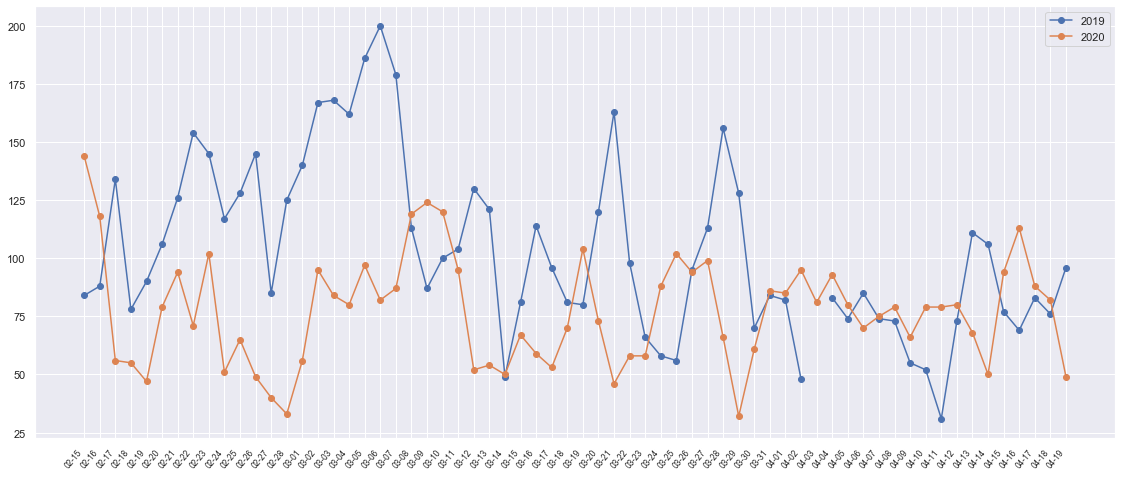

In [387]:
def compare(years,start_date,end_date,data):
    fig = plt.figure()
    fig.autofmt_xdate()
    ax = fig.add_axes([0,0,1,1])
    plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right', fontsize='x-small')
    
    data_arr = []
    for year in years:
        temp_data = data.loc[f'{year}-{start_date}':f'{year}-{end_date}']
        print(f'Mean PM 2.5 concentration in year {year} is',temp_data[' pm25'].mean())
        temp_data.index = temp_data.index.strftime('%m-%d')
        data_arr.append(temp_data)
        ax.plot(temp_data[' pm25'], marker='o', linestyle='-', label=f'{year}')
    ax.legend()
compare(['2019','2020'],'02-15','04-19',data)

In [388]:
X = data[[' pm25']].dropna()
start_date = '03-01'
no_covid = X.loc[:f'2020-{start_date}']
covid = X.loc[f'2020-{start_date}':]

# Testing

In [381]:
from statsmodels.tsa.stattools import adfuller
series = data[' pm25'].dropna()
X = series.values
def adf_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

adf_test(X)

ADF Statistic: -2.765160
p-value: 0.063425
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [302]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(X)

Results of KPSS Test:
Test Statistic            0.361814
p-value                   0.093615
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## Treatment

**Typer of Stationarity**

**Strict Stationary**: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.  
**Trend Stationary**: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.  
**Difference Stationary**: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.

Case 1: Both tests conclude that the series is not stationary -> series is not stationary  
Case 2: Both tests conclude that the series is stationary -> series is stationary  
Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary   
**Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary**  

## Differencing

In [494]:
X = data[' pm25'].dropna()
X = np.log(X)
X = X - X.shift(1)
X = X.dropna()
print('KPSS')
kpss_test(X)
print(' ')
print('ADF')
adf_test(X)

KPSS
Results of KPSS Test:
Test Statistic            0.114965
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
 
ADF
ADF Statistic: -8.982050
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


## Log Transformation

In [54]:
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift(1)

## Processing

In [416]:
data = raw_data.copy()
import datetime
Date = []
for i in data.date:
    temp = i.split('/')
    Date.append(datetime.datetime(int(temp[0]),int(temp[1]),int(temp[2])))
data['Date'] = Date
data.drop(columns=['date'],inplace = True)
data = data.sort_index()
data = data.replace(" ", np.nan)
data.drop(data.tail(1).index,inplace=True)
for i in data.columns:
    data[i]
    ts = data[i].dropna()
    data[i] = pd.to_numeric(ts)
data['Date'] = data['Date'].astype('datetime64[ns]')
data.head()

,pm25,pm10,o3,no2,so2,co,Date
0,95.0,38.0,24.0,29.0,4.0,5.0,2020-04-02
1,81.0,52.0,30.0,34.0,4.0,6.0,2020-04-03
2,93.0,54.0,28.0,18.0,3.0,4.0,2020-04-04
3,80.0,41.0,32.0,16.0,4.0,4.0,2020-04-05
4,70.0,50.0,26.0,35.0,4.0,5.0,2020-04-06


In [417]:
data = data.resample('W-Wed', label='right', closed = 'right', on='Date').mean().reset_index().sort_values(by='Date').set_index('Date')

In [418]:
data.head()

,pm25,pm10,o3,no2,so2,co
Date,,,,,,
2014-01-29,NaN,30.600000,4.333333,53.666667,9.500000,9.666667
2014-02-05,NaN,34.857143,11.714286,38.857143,6.285714,6.714286
2014-02-12,NaN,29.142857,12.285714,43.142857,5.571429,6.428571
2014-02-19,NaN,36.285714,12.857143,53.428571,7.857143,7.571429
2014-02-26,NaN,73.571429,13.000000,69.142857,12.428571,11.714286


## Division

In [482]:
X = data[[' pm25']].dropna()
start_date = '03-15'
no_covid = X.loc[:f'2020-{start_date}']
covid_weekly = X.loc[f'2020-{start_date}':]
train = X.loc[:'2020-01-01']
val = X.loc['2020-01-01':'2020-02-28']

In [483]:
from sklearn.metrics import mean_squared_error
from math import sqrt

## AR Model

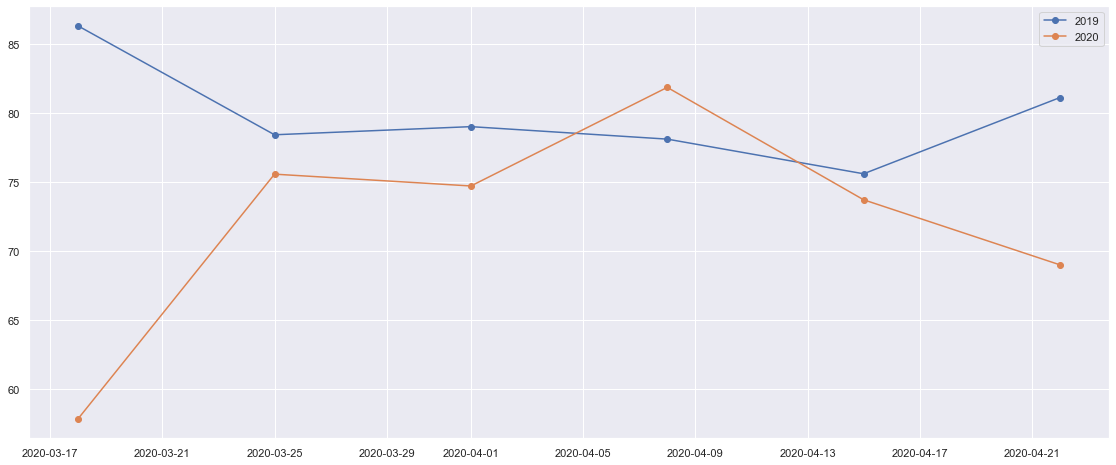

In [492]:
from statsmodels.tsa.ar_model import AR

def predict(data,value):
    ts = data[' pm25'].dropna()
    model = AR(ts.astype(float))
    model_fit = model.fit(trend='nc')
    yhat = model_fit.predict(len(ts), len(ts)+value)
    result[' pm25'] = yhat

result = pd.DataFrame() 
predict(no_covid,5)
result.index=covid_weekly.index
fig = plt.figure()
fig.autofmt_xdate()
ax = fig.add_axes([0,0,1,1])
ax.plot(result, marker='o', linestyle='-',label='2019')
ax.plot(covid_weekly, marker='o', linestyle='-',label='2020')
ax.legend()

### Testing

In [485]:
result = pd.DataFrame()
predict(train,len(val)-1)
sqrt(mean_squared_error(val[' pm25'], result[' pm25']))

9.54971875942028

# MA Model

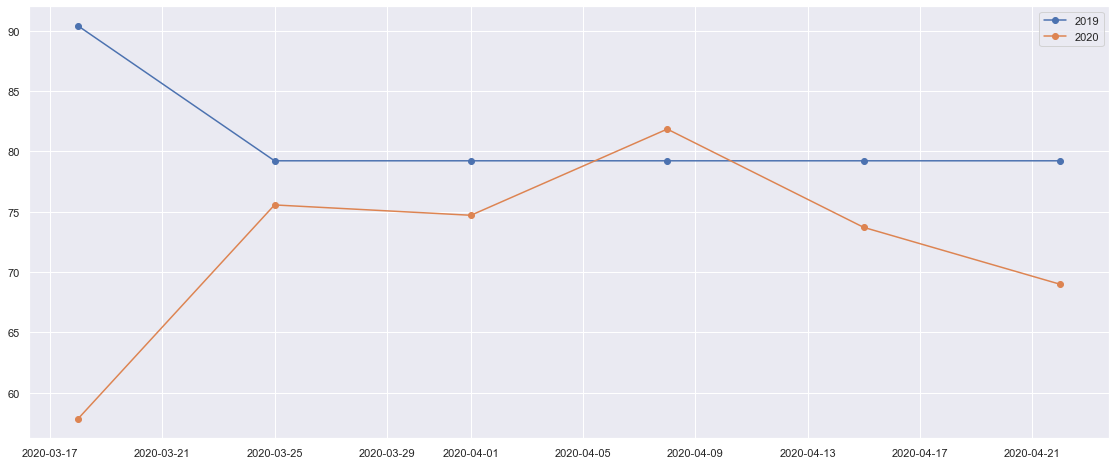

In [486]:
result = pd.DataFrame() 
from statsmodels.tsa.arima_model import ARMA
def predict(data,value):
    ts = data[' pm25'].dropna()
    model = ARMA(ts.astype(float), order=(0, 1))
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(ts), len(ts)+value)
    result[' pm25'] = yhat

predict(no_covid,5)
result.index=covid_weekly.index
fig = plt.figure()
fig.autofmt_xdate()
ax = fig.add_axes([0,0,1,1])
ax.plot(result, marker='o', linestyle='-', label='2019')
ax.plot(covid_weekly, marker='o', linestyle='-', label='2020')
ax.legend()

### Testing

In [487]:
result = pd.DataFrame()
predict(train,len(val)-1)
sqrt(mean_squared_error(result[' pm25'],val[' pm25']))

8.814473925565808

# SARIMA Model

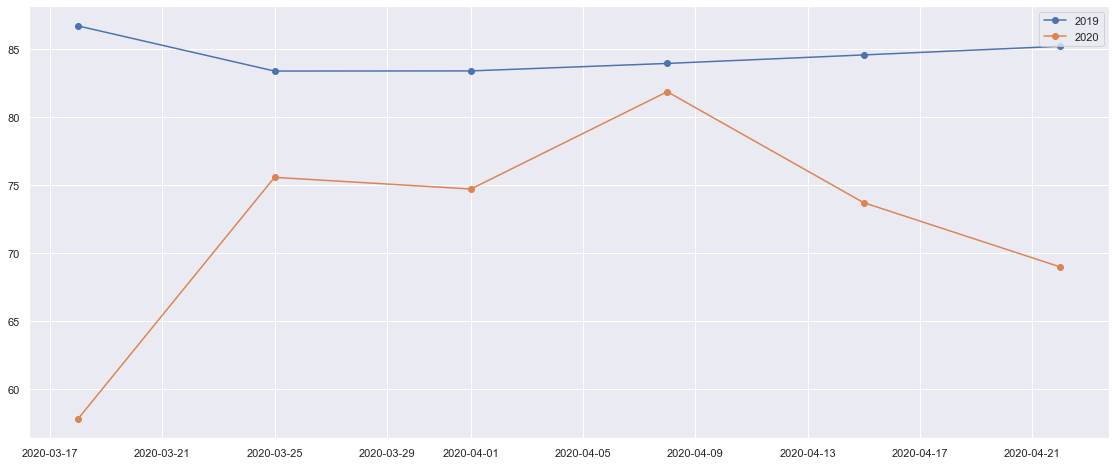

In [488]:
result = pd.DataFrame() 
from statsmodels.tsa.statespace.sarimax import SARIMAX
def predict(data,value):
    ts = data[' pm25'].dropna()
    model = SARIMAX(ts.astype(float), order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(ts), len(ts)+value)
    result[' pm25'] = yhat

predict(no_covid,5)
result.index=covid_weekly.index
fig = plt.figure()
fig.autofmt_xdate()
ax = fig.add_axes([0,0,1,1])
ax.plot(result, marker='o', linestyle='-', label='2019')
ax.plot(covid_weekly, marker='o', linestyle='-', label='2020')
ax.legend()



### Testing

In [489]:
result = pd.DataFrame()
predict(train,len(val)-1)
sqrt(mean_squared_error(val[' pm25'], result[' pm25']))

10.989047495755203